# Amazon Fine Food Reviews Analysis

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [37]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm_notebook as tqdm
import os
from pathlib import Path

from bs4 import BeautifulSoup


# [1]. Reading Data

In [2]:
path = Path('../data/amazon-fine-food/')
list(iter(path.iterdir()))

[PosixPath('../data/amazon-fine-food/database.sqlite')]

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect(path/'database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
df = pd.read_sql_query(""" SELECT * FROM Reviews """, con)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Exploratory analysis

In [4]:
df.shape

(568454, 10)

In [5]:
sns.set_style('whitegrid')

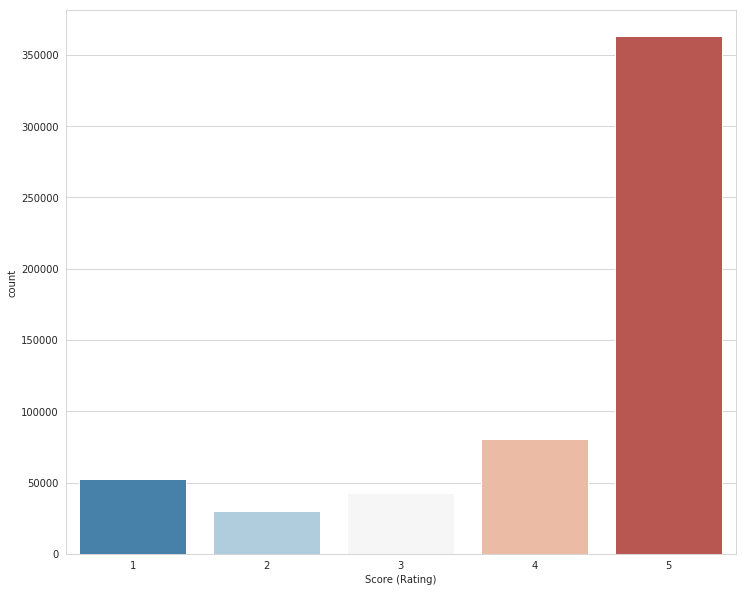

In [6]:
plt.figure(figsize=(12,10))
sns.countplot(x='Score', data=df, palette='RdBu_r')
plt.xlabel('Score (Rating)')
plt.show()

> **Distribution of ratings**
- We see that 5-star reviews constitute a large proportion (64%) of all reviews. 
- The next most prevalent rating is 4-stars(14%), followed by 1-star (9%), 3-star (8%), and finally 2-star reviews (5%).

In [7]:
# filter_df = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
# filter_df.shape

In [8]:
def sentiment_score(x):
    if x > 3:
        return 'positive'
    elif x < 3:
        return 'negetive'
    else:
        return 'neutral'

df['Sentiment'] = df.Score.map(sentiment_score)
print("Number of data points in our data", df.shape)
df.head()

Number of data points in our data (568454, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negetive
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negetive
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


## Helpfulness

In [9]:
def helfulness_score(x):
    score = ''
    if x > 0.75:
        score = '>75%'
    elif x <= 0.75 and x >= 0.25:
        score = '25-75%'
    elif x < 0.25:
        score = '<25%'
    else:
        score = 'invalid'
    return score

df['helfulness'] = ((df.HelpfulnessNumerator / df.HelpfulnessDenominator)
                            .apply(helfulness_score))


df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment,helfulness
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive,>75%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negetive,invalid
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive,>75%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negetive,>75%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive,invalid


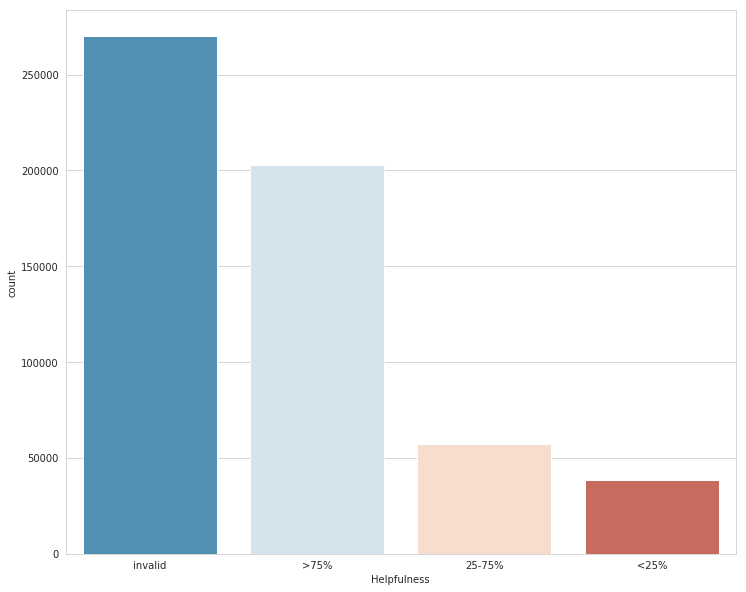

In [10]:
plt.figure(figsize=(12,10))
sns.countplot(x='helfulness', order=['invalid', '>75%', '25-75%', '<25%'], data=df, palette='RdBu_r')
plt.xlabel('Helpfulness')
plt.show()

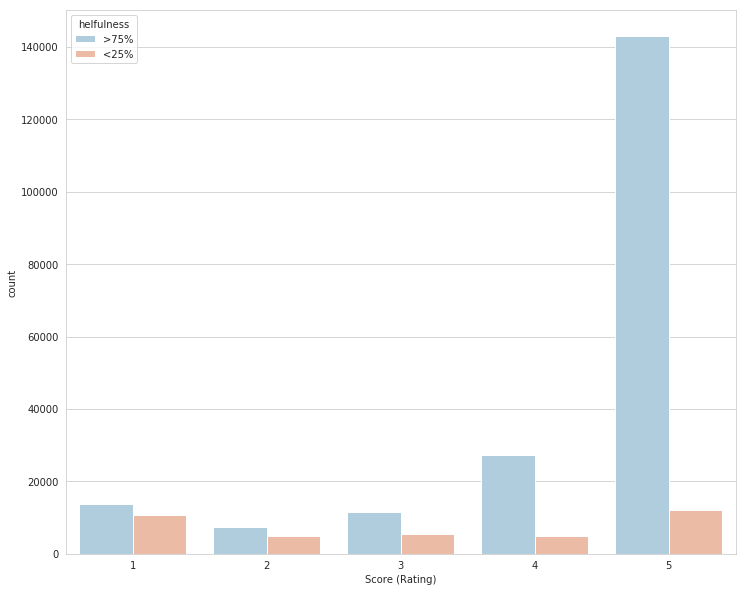

In [11]:
plt.figure(figsize=(12,10))
sns.countplot(x='Score', hue='helfulness', hue_order=['>75%', '<25%'], data=df, palette='RdBu_r')
plt.xlabel('Score (Rating)')
plt.show()

### for knn we are taking only the first 20k points

In [21]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 ORDER BY RANDOM() LIMIT 20000 """, con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

# changing reviews with score less than 3 to be negetive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,446918,B000PC47WK,A2WKLNZ2HJFCTR,Mary Bird,0,0,1,1309392000,Great taste,I have never used a coffee syrup but love Star...
1,131576,B006FC4256,A33PR2TAH0BYRN,"Trudy L. Anthony ""lovebeader""",0,1,1,1338336000,Just what the Dr. ordered,Dr. Flynn's is the best granola I've ever tast...
2,513493,B000612VL4,A3DWYHS89BW5JV,"Leslie Pizzino ""italian mana""",7,7,1,1111536000,Red Velvet Cake - Surprisingly Delicious,Having remembered Red Velvet cake from the sou...


In [22]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(1)
FROM Reviews
GROUP BY userId
HAVING COUNT(1) > 1
""", con)

In [23]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(1)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [24]:
display[display['UserId'] == 'AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(1)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [25]:
display['COUNT(1)'].sum()

393063

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [26]:
display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score !=3 AND UserId="AZY10LLTJ71NX"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,333057,B000MYW2ZA,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",0,0,5,1334707200,works for me. lost 10-15 pounds my first month,I was recommended to try green tea extract to ...
1,35174,B001ATMQK2,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",1,1,5,1296691200,Have you seen how much Ranch 99 is trying to c...,I bought this 6 pack because for the price tha...
2,332195,B001P7AXXG,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",1,1,5,1303776000,BEST MICROWAVE POPCORN EVER!!!!,This popcorn is probably the best microwave po...
3,340773,B0043CVIBG,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",4,4,5,1303776000,girl scout thin mint in disguise,if you love thin mint cookies that the girl sc...
4,404703,B006P7E5ZI,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",0,0,5,1334707200,works for me. lost 10-15 pounds my first month,I was recommended to try green tea extract to ...


As can be seen above the same user has multiple reviews of the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B001P7AXXG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B0043CVIBG was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [27]:
sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [28]:
# Deduplication of entries
final = sorted_data.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, keep='first', inplace=False)
final.shape

(19288, 10)

In [29]:
# Checking to see how much of data still remains
(final['Id'].size * 1.0) / (filtered_data['Id'].size*1.0) * 100

96.44

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [30]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [31]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [32]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(19288, 10)


1    16296
0     2992
Name: Score, dtype: int64

In [33]:
final.sample(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
5636,309,B003YDP5PA,AAZ084UMH8VZ2,"D. L. Brown ""A Knower Of Good Things""",3,3,1,1299196800,One of my Favoritte foods,Try this you might like it. I did and I am qui...
7653,11252,B0007ZKS00,A2ZPKV563FR4NS,"Kim S. Pierman ""love soft hands""",1,1,1,1136160000,Jamaican all the way!,"Since my first trip to Jamaica, I fell in love..."
2839,271965,B001QEEZX2,A36QWBAEC0FNFW,Marie Brandt,1,1,1,1297296000,"Expensive, but good food",I switched to this food when my cocker spaniel...
2283,409934,B0046IAJFI,A26JM72JIRAOF8,SR,2,2,1,1304035200,Great!,I was quite impressed by these chews! My dog ...
1032,496763,B005HG9ET0,A30LSAC7UMZDWS,"Robert L. Hylton ""Mindbodysoul""",1,1,1,1349222400,Facts you should know about this water,We all know cancer thrifts on a acidic Ph. So...


# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [38]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
    

In [40]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [41]:
stemmer = SnowballStemmer('english')

In [42]:
le=WordNetLemmatizer()

In [43]:
# Combining all the above
preprocessed_reviews = []
preprocessed_reviews_stem = []
preprocessed_reviews_lema = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence= sentence.lower().split()
    sentence_norm = ' '.join(e for e in sentence if e.lower() not in stopwords)
    sentence_stem = ' '.join(stemmer.stem(e) for e in sentence if e.lower() not in stopwords)
    sentence_lema = ' '.join(le.lemmatize(e) for e in sentence if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence_norm.strip())
    preprocessed_reviews_stem.append(sentence_stem.strip())
    preprocessed_reviews_lema.append(sentence_lema.strip())
    

In [44]:
preprocessed_reviews[1500]

'hubby loves cookies would eat entire shipment one week would let'

In [45]:
preprocessed_reviews_stem[1500]

'hubbi love cooki would eat entir shipment one week would let'

In [46]:
preprocessed_reviews_lema[1500]

'hubby love cooky would eat entire shipment one week would let'

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [47]:
preprocessed_summary = []
preprocessed_summary_stem = []
preprocessed_summary_lema = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence= sentence.lower().split()
    sentence_norm = ' '.join(e for e in sentence if e.lower() not in stopwords)
    sentence_stem = ' '.join(stemmer.stem(e) for e in sentence if e.lower() not in stopwords)
    sentence_lema = ' '.join(le.lemmatize(e) for e in sentence if e.lower() not in stopwords)
    preprocessed_summary.append(sentence_norm.strip())
    preprocessed_summary_stem.append(sentence_stem.strip())
    preprocessed_summary_lema.append(sentence_lema.strip())
    

In [48]:
preprocessed_summary[2000]

'maybe best damn chocolate chip cookies ever'

In [49]:
preprocessed_summary_stem[2000]

'mayb best damn chocol chip cooki ever'

In [50]:
preprocessed_summary_lema[2000]

'maybe best damn chocolate chip cooky ever'

# [4] Featurization

## [4.1] BAG OF WORDS

In [51]:
#BoW

count_vect = CountVectorizer() # in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ", type(final_counts))
print("the shape of out text BOW vectorizer ", final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names ['aa', 'aaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaand', 'aafco', 'aamazon', 'aarrgh', 'aash', 'aback']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (19288, 27680)
the number of unique words  27680


In [52]:
final_counts.shape

(19288, 27680)

## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=20000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ", type(final_bigram_counts))
print("the shape of out text BOW vectorizer ", final_bigram_counts.get_shape())
print("the number of unique words ", final_bigram_counts.get_shape()[1])


## [4.3] TF-IDF

In [185]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1, 2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely loves', 'absolutely no']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4955, 3190)
the number of unique words including both unigrams and bigrams  3190


## [4.4] Word2Vec

In [186]:
# Train your own Word2Vec model using your own text corpus
i = 0
list_of_sentance = []
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [187]:
model_path = Path('../models')
list(iter(model_path.iterdir()))

[PosixPath('../models/GoogleNews-vectors-negative300.bin')]

In [188]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
is_your_ram_gt_16g= True
want_to_use_google_w2v = True
want_to_train_w2v = False

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile(model_path/'GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format(model_path/'GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.798933207988739), ('fantastic', 0.7935212254524231), ('tremendous', 0.7748855948448181), ('wonderful', 0.7647868990898132), ('good', 0.7291510701179504), ('incredible', 0.7032873630523682), ('marvelous', 0.6971102952957153), ('phenomenal', 0.6841564178466797), ('amazing', 0.6634127497673035), ('awesome', 0.6510507464408875)]
[('Worst', 0.6146091222763062), ('weakest', 0.6143776774406433), ('scariest', 0.5957258343696594), ('ugliest', 0.5931180119514465), ('best', 0.5835111141204834), ('bleakest', 0.5718506574630737), ('strongest', 0.5671455264091492), ('nastiest', 0.5644308924674988), ('lousiest', 0.5631451606750488), ('toughest', 0.5624396204948425)]


In [189]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:100])

number of words that occured minimum 5 times  3000000
sample words  ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', '$', 'had', 'year', 'were', 'we', 'more', '###', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out', 'can', 'It', 'all', 'also', 'two', 'after', 'first', 'He', 'do', 'time', 'than', 'when', 'We', 'over', 'last', 'new', 'other', 'her', 'people', 'into', 'In', 'our', 'there', 'A', 'she', 'could', 'just', 'years', 'some', 'U.S.', 'three', 'million', 'them', 'what', 'But', 'so', 'no', 'like', 'if', 'only', 'percent', 'get', 'did', 'him', 'game', 'back', 'because', 'now', '#.#', 'before']


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words = 0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [75]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value

dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [77]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []
row = 0
for sent in tqdm(list_of_sentance):
    sent_vec = np.zeros(300)
    weight_sum = 0
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word] * (sent.count(word) / len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [06:59<00:00, 11.89it/s]


# [5] Applying TSNE

<ol> 
    <li> 4 tsne plots with each of these feature set
        <ol>
            <li>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ol>
    </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points </font></li>
</ol>

In [55]:
sns.set_style('whitegrid');
plt.figure(figsize=(15, 12));

<Figure size 1080x864 with 0 Axes>

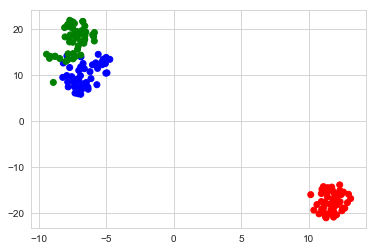

In [56]:
# https://github.com/pavlin-policar/fastTSNE you can try this also, this version is little faster than sklearn 
import numpy as np
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

iris = datasets.load_iris()
x = iris['data']
y = iris['target']

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

In [57]:
x.shape

(150, 4)

## [5.1] Applying TNSE on Text BOW vectors

In [58]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    
    

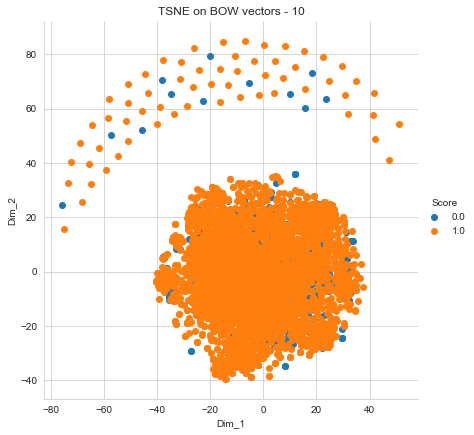

In [67]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0,perplexity=10,n_iter=1000)

tsne_data = model.fit_transform(final_counts.toarray())


tsne_data = np.vstack((tsne_data.T, final['Score'])).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))


sns.FacetGrid(tsne_df, hue="Score", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE on BOW vectors - 10')
plt.show()

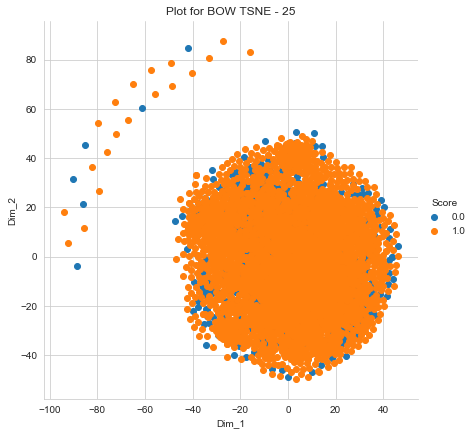

In [68]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0,perplexity=25,n_iter=1000)

tsne_data = model.fit_transform(final_counts.toarray())


tsne_data = np.vstack((tsne_data.T, final['Score'])).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))


sns.FacetGrid(tsne_df, hue="Score", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Plot for BOW TSNE - 25')
plt.show()

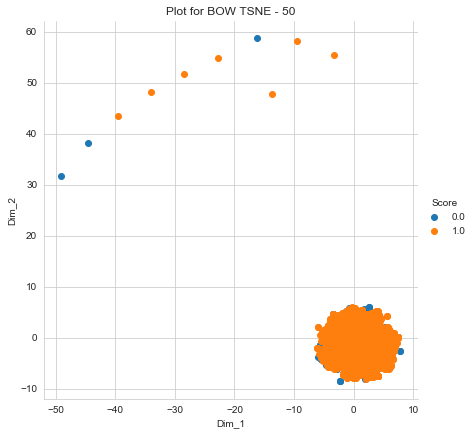

In [69]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=1000)

tsne_data = model.fit_transform(final_counts.toarray())


tsne_data = np.vstack((tsne_data.T, final['Score'])).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))


sns.FacetGrid(tsne_df, hue="Score", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Plot for BOW TSNE - 50')
plt.show()

## [5.3] Applying TNSE on Text Avg W2V vectors

In [48]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

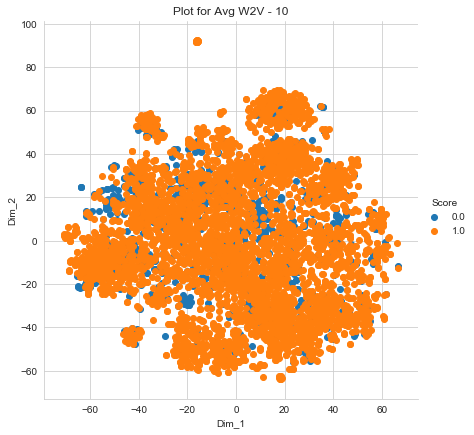

In [70]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0,perplexity=10,n_iter=1000)

tsne_data = model.fit_transform(sent_vectors)


tsne_data = np.vstack((tsne_data.T, final['Score'])).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))


sns.FacetGrid(tsne_df, hue="Score", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Plot for Avg W2V - 10')
plt.show()

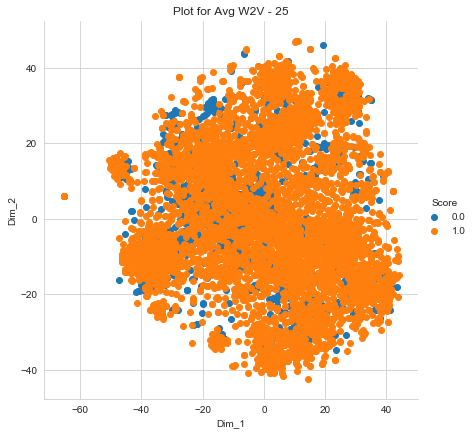

In [71]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0,perplexity=25,n_iter=1000)

tsne_data = model.fit_transform(sent_vectors)


tsne_data = np.vstack((tsne_data.T, final['Score'])).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))


sns.FacetGrid(tsne_df, hue="Score", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Plot for Avg W2V - 25')
plt.show()

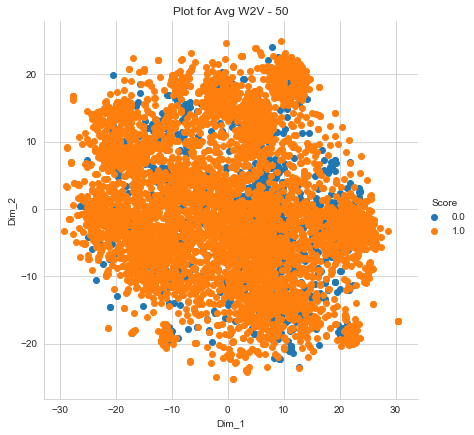

In [72]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=1000)

tsne_data = model.fit_transform(sent_vectors)


tsne_data = np.vstack((tsne_data.T, final['Score'])).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))


sns.FacetGrid(tsne_df, hue="Score", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Plot for Avg W2V - 50')
plt.show()

## [5.4] Applying TNSE on Text TFIDF weighted W2V vectors

In [49]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

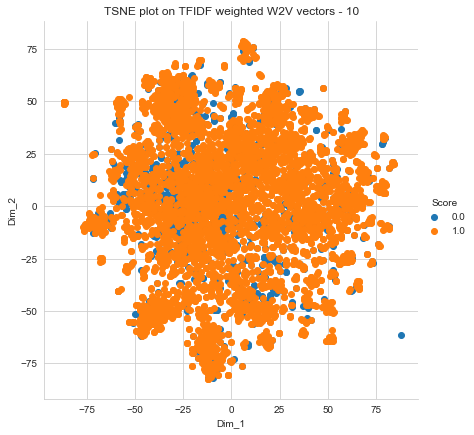

In [78]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0,perplexity=10,n_iter=1000)

tsne_data = model.fit_transform(tfidf_sent_vectors)


tsne_data = np.vstack((tsne_data.T, final['Score'])).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))


sns.FacetGrid(tsne_df, hue="Score", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE plot on TFIDF weighted W2V vectors - 10')
plt.show()

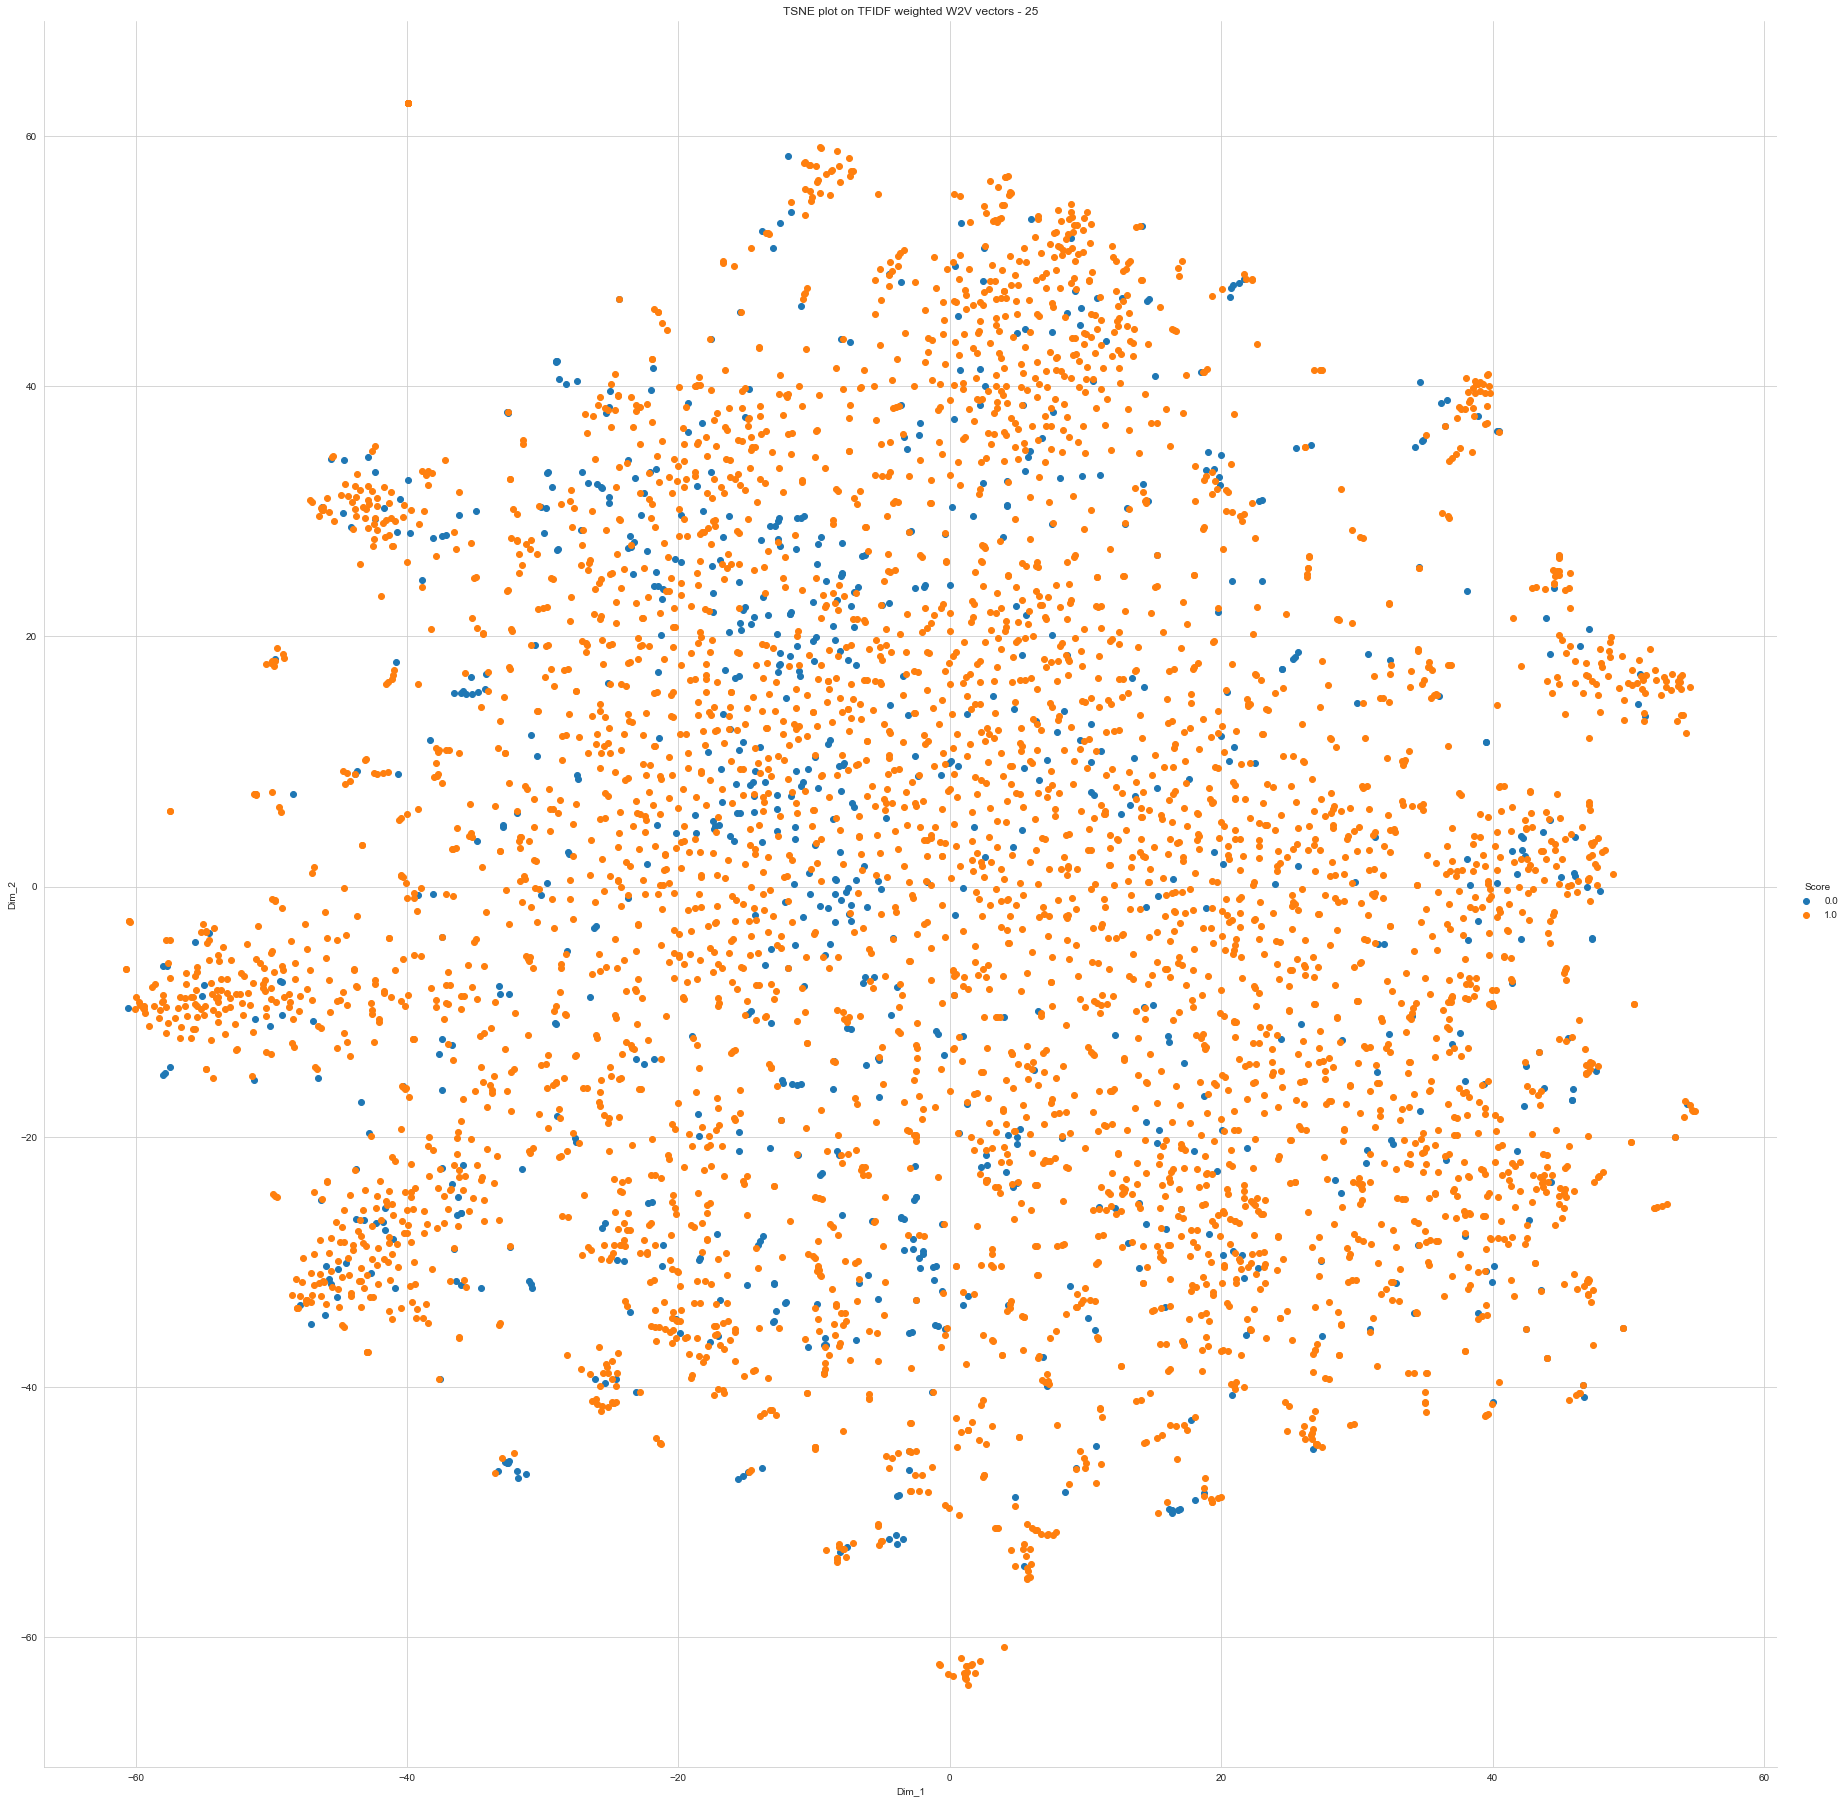

In [80]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0,perplexity=25,n_iter=1000)

tsne_data = model.fit_transform(tfidf_sent_vectors)


tsne_data = np.vstack((tsne_data.T, final['Score'])).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))


sns.FacetGrid(tsne_df, hue="Score", height=25).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE plot on TFIDF weighted W2V vectors - 25')
plt.show()

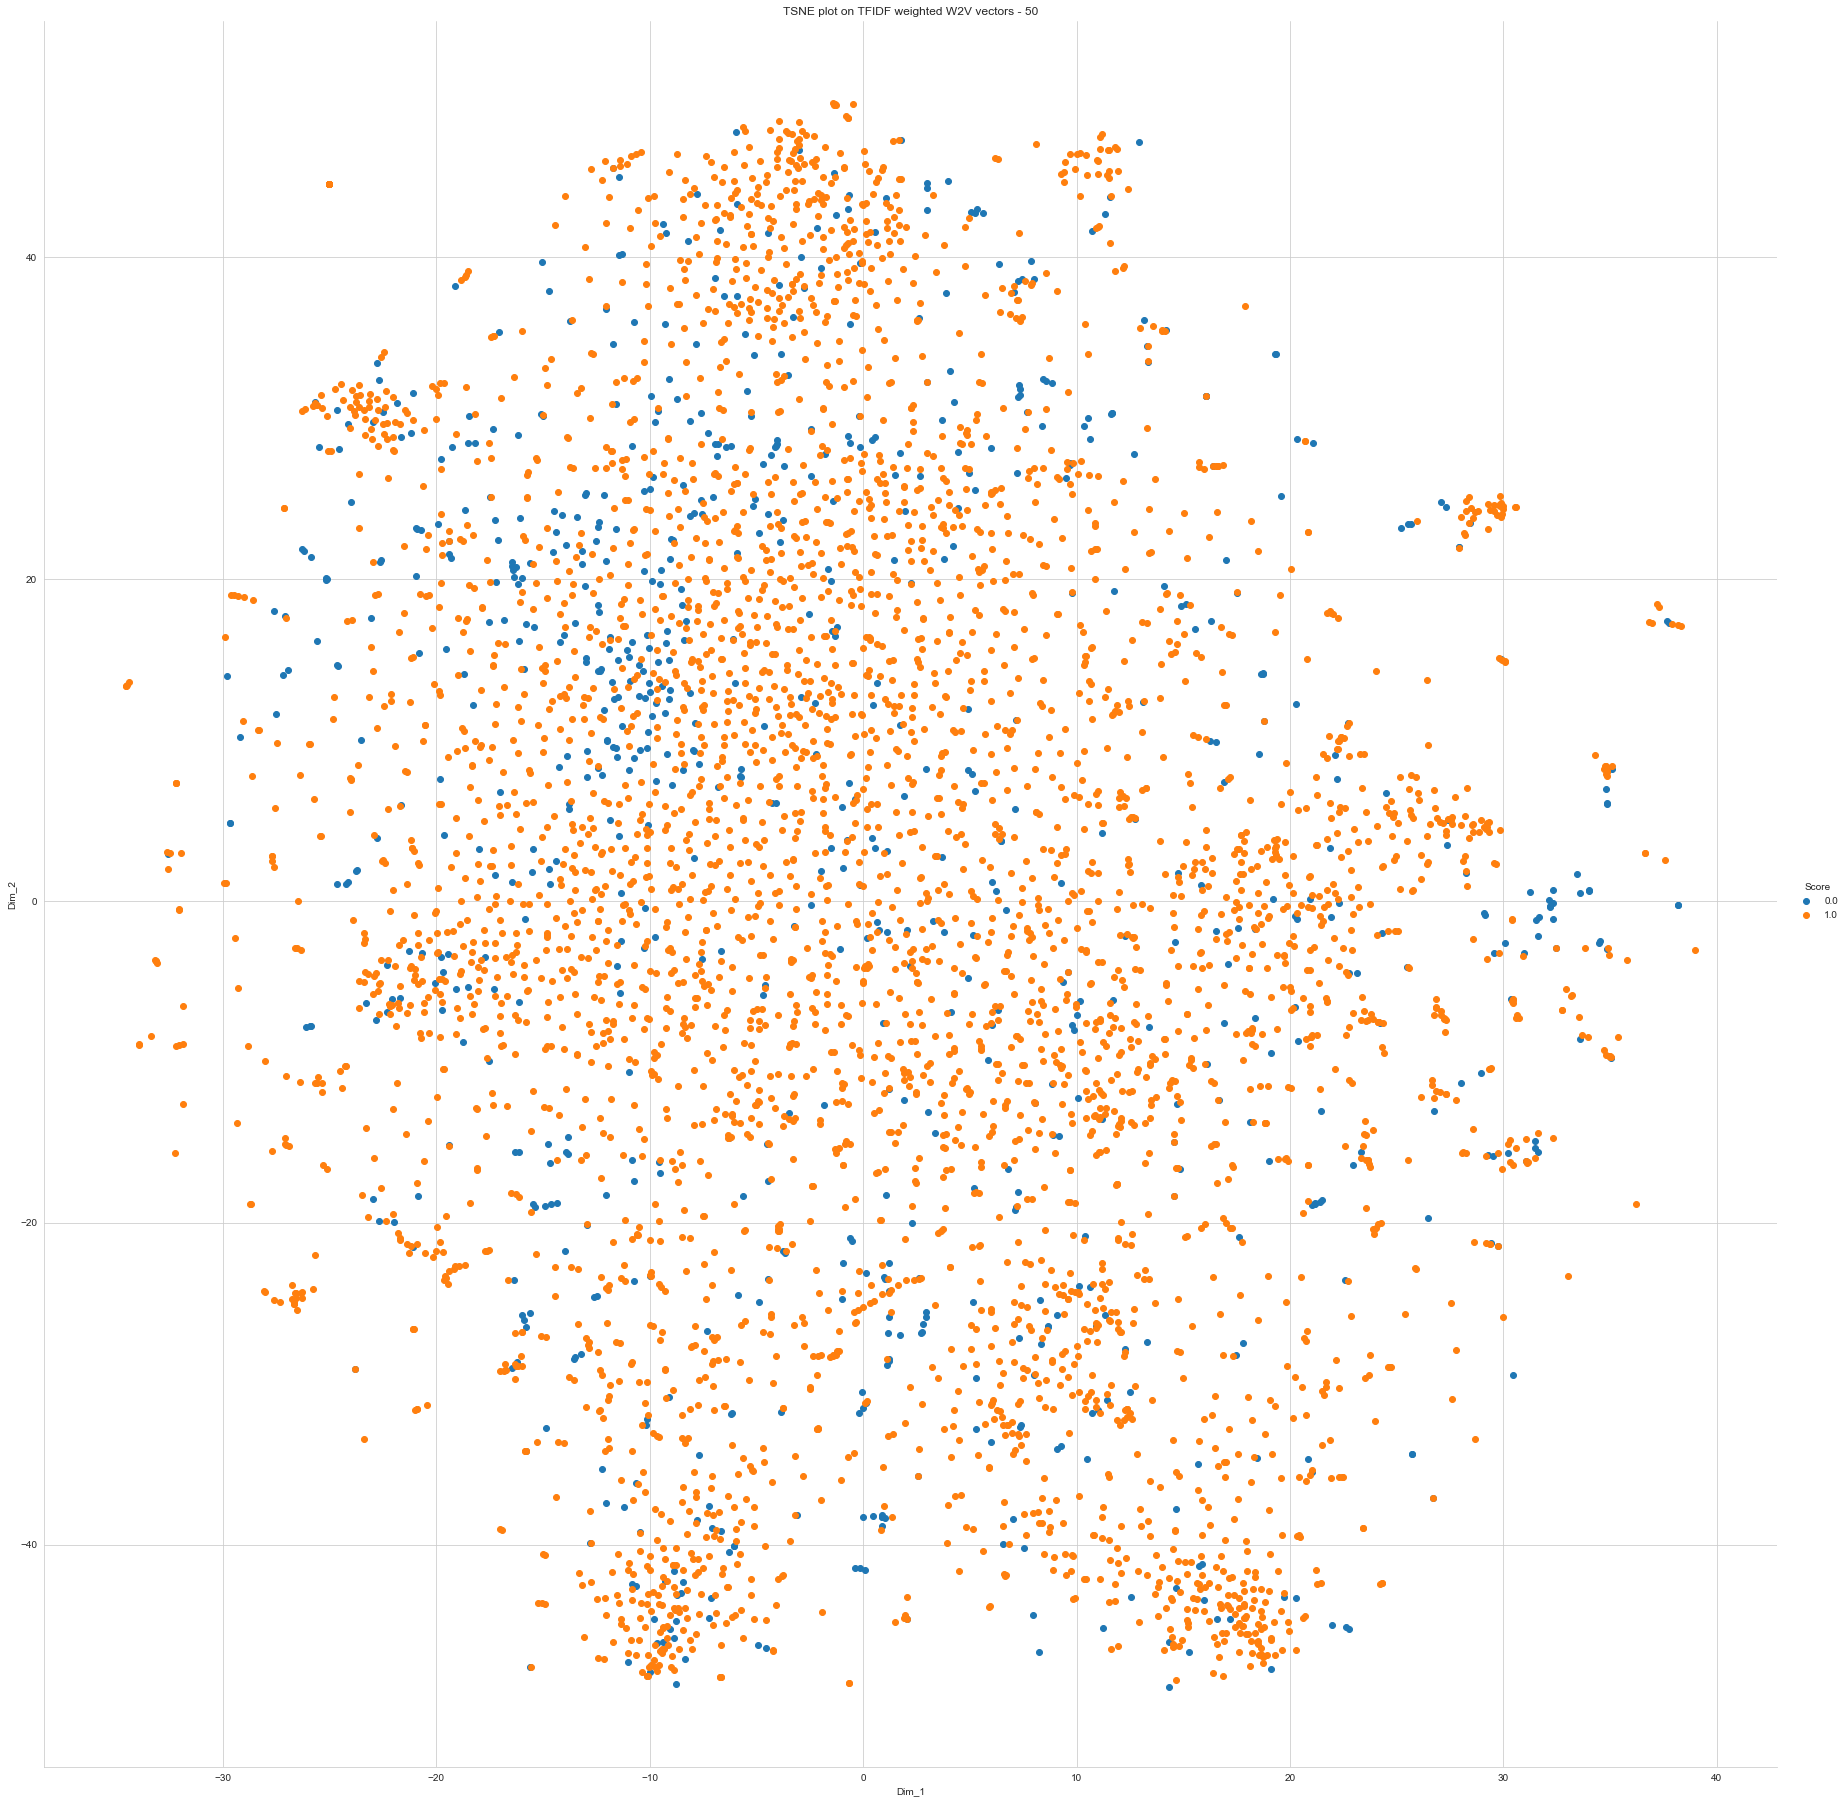

In [81]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=1000)

tsne_data = model.fit_transform(tfidf_sent_vectors)


tsne_data = np.vstack((tsne_data.T, final['Score'])).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))


sns.FacetGrid(tsne_df, hue="Score", height=25).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE plot on TFIDF weighted W2V vectors - 50')
plt.show()

# [6] Conclusions

- 1. **TSNE on BOW**: The plot for perplexity 10, 25, 50 is very dense and the positive and negetive classes are very densely overlapped. The increase in perplexity makes the plots more dense.

- 2. **TSNE on Avg W2V vectors**: The plot for perplexity 10, 25, 50 is very dense and the positive and negetive classes are very densely overlapped. There is hardly any change for plots using different perplexity.

- 3. **TSNE on TFIDF weighted W2V vectors**: The plot for perplexity 10 is very dense and the positive and negetive classes are very densely overlapped. The plots for perplexity 25 is very widely spread out still the positive and negetive classes are overlapping.